# 3 regularizetion

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

/home/student/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


reload data we saved in assigment1

In [2]:
import os
data_root = '/home/student/project/project-01/nlp_bots/hw-xujing'
pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')
pickle_file1 = os.path.join(data_root, 'notMNIST.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del(save)
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8947, 28, 28) (8947,)
test set (8691, 28, 28) (8691,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (8947, 784) (8947, 10)
Test set (8691, 784) (8691, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
           / predictions.shape[0])

# problem 1

Tune L2 regularizition for both logisitc and neural network

In [5]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    #input data, training data using placeholder
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #variables
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    #training computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    #original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    #Loss function using L2 regularizition
    regularizer = beta_regul*tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(loss + regularizer)
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #predictions for the training, validation and test
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) +biases)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
num_steps = 3001
##3001*128 总共的训练数据   ## 之前是801*10000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        ##分母减去batch_size是防止当batch_size不能被训练数据量整除时，offset:(offset + batch_size)超出数组界限
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.747681
Minibatch accuracy: 5.5%
Validation accuracy: 11.4%
Minibatch loss at step 500: 3.141049
Minibatch accuracy: 72.7%
Validation accuracy: 73.2%
Minibatch loss at step 1000: 1.726962
Minibatch accuracy: 78.1%
Validation accuracy: 76.3%
Minibatch loss at step 1500: 1.194721
Minibatch accuracy: 80.5%
Validation accuracy: 78.3%
Minibatch loss at step 2000: 0.899220
Minibatch accuracy: 82.0%
Validation accuracy: 79.8%
Minibatch loss at step 2500: 0.736119
Minibatch accuracy: 84.4%
Validation accuracy: 79.8%
Minibatch loss at step 3000: 1.093994
Minibatch accuracy: 75.8%
Validation accuracy: 80.4%
Test accuracy: 87.9%


test the different value of L2 regulariition parameters in ACC

In [7]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        #f.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [8]:
import matplotlib.pyplot as plt

Text(0.5,1,'Test accuracy by regularization (logistic)')

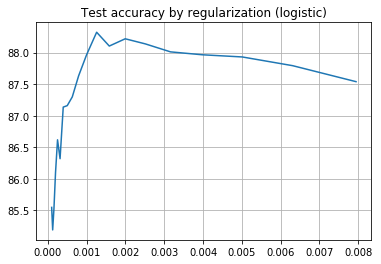

In [9]:
plt.plot(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')

neural network with L2

In [10]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # input data training data use a placeholder that will be fed 
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    
    #original loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    #L2 regularization
    regularizer = beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    loss = tf.reduce_mean(loss + regularizer)
    
    #optimizer 
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #predictions for the training, validation, test data
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) +biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) +biases2)

In [11]:
num_steps = 3001 # data quantity 3001*128
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #pick an offset within the training data, which has been randomized
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #generate a minibatch
        batch_data = train_dataset[offset:(offset+ batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #prepare a dictionary telling the session where to feed the minibatch
        # the key of the dictionary is the placeholder node of the graph to be fed,
        #and the value is the numpy array to feed to it
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accurracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 645.278381
Minibatch accracy: 9.4%
Validation accuracy: 28.0%
Minibatch loss at step 500: 199.720947
Minibatch accracy: 76.6%
Validation accuracy: 79.0%
Minibatch loss at step 1000: 116.298141
Minibatch accracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 1500: 68.671471
Minibatch accracy: 84.4%
Validation accuracy: 81.9%
Minibatch loss at step 2000: 41.250896
Minibatch accracy: 86.7%
Validation accuracy: 83.7%
Minibatch loss at step 2500: 24.994606
Minibatch accracy: 91.4%
Validation accuracy: 85.1%
Minibatch loss at step 3000: 15.610190
Minibatch accracy: 83.6%
Validation accuracy: 86.4%
Test accurracy: 92.1%


In [12]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            #pick an offset within the training data, which has been randomized
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            #generate a minibatch
            batch_data = train_dataset[offset:(offset+ batch_size), :]
            batch_labels = train_labels[offset:(offset+ batch_size), :]
            #prepare a dictionary telling teh session where to feed teh minibatch
            #the key of the dictionary is the placeholder node of the graph to be fed
            #the value is the numpy array to feed to it
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Text(0.5,1,'Test accuracy by regularization (1-layer neural network)')

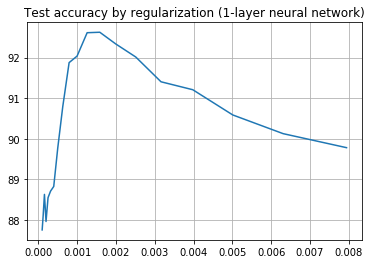

In [13]:
plt.plot(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer neural network)')

# probem 2

over fitting case too few batches

In [14]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    #input training data with placeholder
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) #28*28 * 1024
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes])) #1024
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) #1024 * num_labels
    biases2 = tf.Variable(tf.zeros([num_labels])) # num_labels
    
    # training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) +biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    
    #original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    # regularizer = beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    # loss = tf.reduce_mean(loss + regularizer)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #predictions for training validation, test data
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) +biases2)

In [15]:
num_steps = 101
num_batches = 3
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] -batch_size) # small data training over again
        #generate a minibatch
        batch_data = train_dataset[offset:(offset+ batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # minibatch dictionary (placeholder node of the graph tobe fed) : numpy array to feed to 
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, prediction = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 10 ==0):
            print('minibatch loss at step %d: %f' % (step, l))
            print('minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
minibatch loss at step 0: 332.258667
minibatch accuracy: 11.7%
validation accuracy: 25.5%
minibatch loss at step 10: 60.674568
minibatch accuracy: 12.5%
validation accuracy: 70.5%
minibatch loss at step 20: 1.532516
minibatch accuracy: 8.6%
validation accuracy: 71.2%
minibatch loss at step 30: 0.000000
minibatch accuracy: 11.7%
validation accuracy: 71.2%
minibatch loss at step 40: 0.941779
minibatch accuracy: 12.5%
validation accuracy: 71.3%
minibatch loss at step 50: 0.794447
minibatch accuracy: 8.6%
validation accuracy: 71.2%
minibatch loss at step 60: 0.000000
minibatch accuracy: 11.7%
validation accuracy: 71.2%
minibatch loss at step 70: 0.715169
minibatch accuracy: 12.5%
validation accuracy: 71.3%
minibatch loss at step 80: 0.139666
minibatch accuracy: 8.6%
validation accuracy: 71.2%
minibatch loss at step 90: 0.000000
minibatch accuracy: 11.7%
validation accuracy: 71.2%
minibatch loss at step 100: 0.000270
minibatch accuracy: 12.5%
validation accuracy: 71.2%
test accu

# probelm 3

introduce dorpout to hidden layer during training in overfitting case

The logic behind "dropout" --- "dropout" means we randomly deactivate a certain number of neurons in the network during training, so it is like we are drawing a random "sample" from different network structures and by "averaging" the predictions produced by those different networks, we reduce the error related to overfitting (i.e., the model becomes more generalizable on the test data).

In [23]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32) ##addL2

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))##隐藏层1024个节点
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.##设置神经网络tf.nn.relu()里的参数相当于逻辑回归的函数logits
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5) #add drop
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
    #+beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))##add L2
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [24]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        ##这里把相当于固定很小一部分的训练数据，然后一直训练这部分数据，所以可得到过拟合现象
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 393.787567
Minibatch accuracy: 9.4%
Validation accuracy: 36.5%
Minibatch loss at step 10: 54.292122
Minibatch accuracy: 82.0%
Validation accuracy: 72.0%
Minibatch loss at step 20: 14.013303
Minibatch accuracy: 93.0%
Validation accuracy: 73.9%
Minibatch loss at step 30: 5.676493
Minibatch accuracy: 95.3%
Validation accuracy: 75.6%
Minibatch loss at step 40: 2.494643
Minibatch accuracy: 95.3%
Validation accuracy: 75.4%
Minibatch loss at step 50: 3.716099
Minibatch accuracy: 96.9%
Validation accuracy: 75.3%
Minibatch loss at step 60: 3.858839
Minibatch accuracy: 96.9%
Validation accuracy: 76.2%
Minibatch loss at step 70: 0.717485
Minibatch accuracy: 98.4%
Validation accuracy: 76.8%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.4%
Minibatch loss at step 90: 1.094872
Minibatch accuracy: 99.2%
Validation accuracy: 76.1%
Minibatch loss at step 100: 3.934409
Minibatch accuracy: 99.2%
Validation accuracy: 76.5%
Test 

# problem 4

Another one is to use learning rate decay:
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
tf.train.exponential_decay(
learning_rate,
global_step,
decay_steps,
decay_rate,
staircase=False,
name=None,)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [25]:
tf.train.exponential_decay??

In [27]:
#2层神经网络
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    #第一层输入节点是28*28级原始数据的维度大小，本层节点是个数是num_hidden_nodes1
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
    #第二层的输入节点是第一层节点个数，本层节点个数是num_hidden_nodes2,stddev是指定生成数据的标准差
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    #最后一层的输入节点个数是第二层节点个数，本层节点个数是要分类的类别个数。
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [28]:
num_steps = 9001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.267127
Minibatch accuracy: 10.9%
Validation accuracy: 28.6%
Minibatch loss at step 500: 1.135358
Minibatch accuracy: 82.0%
Validation accuracy: 84.7%
Minibatch loss at step 1000: 0.772177
Minibatch accuracy: 87.5%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.681346
Minibatch accuracy: 91.4%
Validation accuracy: 86.3%
Minibatch loss at step 2000: 0.559601
Minibatch accuracy: 89.8%
Validation accuracy: 87.5%
Minibatch loss at step 2500: 0.468889
Minibatch accuracy: 93.0%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.757255
Minibatch accuracy: 85.2%
Validation accuracy: 88.4%
Minibatch loss at step 3500: 0.536709
Minibatch accuracy: 85.2%
Validation accuracy: 88.5%
Minibatch loss at step 4000: 0.542546
Minibatch accuracy: 86.7%
Validation accuracy: 88.6%
Minibatch loss at step 4500: 0.427785
Minibatch accuracy: 93.0%
Validation accuracy: 89.0%
Minibatch loss at step 5000: 0.465918
Minibatch accuracy: 90.6%
Validation accurac

In [29]:
#三层神经网络
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, 
                                                num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+ tf.nn.l2_loss(weights4))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [30]:
num_steps = 18001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.466478
Minibatch accuracy: 6.2%
Validation accuracy: 33.1%
Minibatch loss at step 500: 1.262836
Minibatch accuracy: 82.8%
Validation accuracy: 83.5%
Minibatch loss at step 1000: 0.833835
Minibatch accuracy: 87.5%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.735379
Minibatch accuracy: 89.8%
Validation accuracy: 85.5%
Minibatch loss at step 2000: 0.605900
Minibatch accuracy: 87.5%
Validation accuracy: 86.9%
Minibatch loss at step 2500: 0.468212
Minibatch accuracy: 91.4%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.730717
Minibatch accuracy: 84.4%
Validation accuracy: 86.8%
Minibatch loss at step 3500: 0.567295
Minibatch accuracy: 87.5%
Validation accuracy: 87.4%
Minibatch loss at step 4000: 0.690929
Minibatch accuracy: 81.2%
Validation accuracy: 87.3%
Minibatch loss at step 4500: 0.404070
Minibatch accuracy: 92.2%
Validation accuracy: 88.4%
Minibatch loss at step 5000: 0.455640
Minibatch accuracy: 89.1%
Validation accuracy

In [31]:
###3层神经网络+随机失活(dropout)
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, 
                                                num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(lay2_train, 0.5)
    lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(lay3_train, 0.5)
    logits = tf.matmul(drop3, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) #+ \
     # beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+tf.nn.l2_loss(weights4))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)